**Table of contents**<a id='toc0_'></a>    
- 1. [First test results](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**GOALS**:
- get tracking information.
- Understand why the MLflow ui does not show all runs...
- Prepare some plotting and choose the final model.

In [44]:
from project_tools import utils
import pandas as pd
import matplotlib.pyplot as plt

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>First test results

In [19]:
exp_name = 'all_features_minmax_knn'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=False)

In [20]:
results.parent_run_name.value_counts()

parent_run_name
Lasso-type Logistic Regression    100
Random Forest                      50
Rigde-type Logistic Regression     50
Name: count, dtype: int64

In [21]:
results.shape

(204, 45)

The UI did not show lasso-type logistic regressions tracking, so I launched it a second time.

I see the 3 models with one being tuned 2 times (so $50\times4 + 4 parentruns$).

Now, it does not show ridge-type anymore...

In [22]:
results.isnull().mean()

experiment_id                                       0.000000
status                                              0.000000
artifact_uri                                        0.000000
start_time                                          0.000000
end_time                                            0.000000
metrics.test_loss_of_income                         0.019608
metrics.CV_recall_specificity_G_mean                0.019608
metrics.test_threshold_AUC                          0.019608
metrics.CV_AUC                                      0.019608
metrics.test_f2                                     0.019608
metrics.test_threshold_f2                           0.019608
metrics.test_threshold_loss_of_income               0.019608
metrics.test_AUC                                    0.019608
metrics.CV_threshold_f2                             0.019608
metrics.test_recall_specificity_G_mean              0.019608
metrics.CV_threshold_loss_of_income                 0.019608
metrics.CV_loss_of_incom

In [23]:
results.status.value_counts()

status
FINISHED    204
Name: count, dtype: int64

In [30]:
results.columns

Index(['experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time',
       'metrics.test_loss_of_income', 'metrics.CV_recall_specificity_G_mean',
       'metrics.test_threshold_AUC', 'metrics.CV_AUC', 'metrics.test_f2',
       'metrics.test_threshold_f2', 'metrics.test_threshold_loss_of_income',
       'metrics.test_AUC', 'metrics.CV_threshold_f2',
       'metrics.test_recall_specificity_G_mean',
       'metrics.CV_threshold_loss_of_income', 'metrics.CV_loss_of_income',
       'metrics.CV_f2', 'metrics.CV_threshold_recall_specificity_G_mean',
       'metrics.CV_threshold_AUC',
       'metrics.test_threshold_recall_specificity_G_mean',
       'params.class_weight', 'params.solver', 'params.C',
       'params.min_samples_leaf', 'params.max_depth', 'params.criterion',
       'params.min_samples_split', 'params.n_estimators', 'tags.optimizer',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.stratified_cv', 'tags.mlflow.runName', 'tags.mlflow.parentRunId',


In [31]:
results[['params.class_weight', 'params.solver', 'params.C']].head()

,params.class_weight,params.solver,params.C
run_id,,,
b54203793634400cbf49895bd579fc60,None,liblinear,0.31423484282449005
760cf457afda4a1db47888a181919e65,None,liblinear,0.30076560914413636
cd67b1a2350e4b939231bb2714c0a5d8,None,liblinear,0.2965396244206103
91bb0657a20d44fd825dbbfa861a00ce,None,liblinear,0.18545765719736262
7d2561e58d6945f58f2533194395699b,None,liblinear,0.17929562035794164


In [24]:
results2 = utils.get_runs_information(exp_id, light_version=True)

In [26]:
results2.head(50)

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
b54203793634400cbf49895bd579fc60,0.709632,469.0,0.460277,0.661836,144.0,0.394737,4.919,Lasso-type Logistic Regression
760cf457afda4a1db47888a181919e65,0.709632,470.0,0.460277,0.662167,145.0,0.395570,4.425,Lasso-type Logistic Regression
cd67b1a2350e4b939231bb2714c0a5d8,0.710655,473.0,0.462025,0.660804,145.0,0.394737,3.973,Lasso-type Logistic Regression
91bb0657a20d44fd825dbbfa861a00ce,0.711276,474.0,0.461165,0.681405,144.0,0.414013,5.134,Lasso-type Logistic Regression
7d2561e58d6945f58f2533194395699b,0.716031,474.0,0.468370,0.680043,144.0,0.412698,4.816,Lasso-type Logistic Regression
8249de61b3be4983b77f2b77ca985746,0.713562,474.0,0.461802,0.680043,144.0,0.412698,4.398,Lasso-type Logistic Regression
6359247ac5a9456587ca903804693f1a,0.715008,474.0,0.466667,0.680043,144.0,0.412698,5.112,Lasso-type Logistic Regression
6df8d1cbd18e4f38a0b48c4f45ccb059,0.711338,474.0,0.463198,0.670176,148.0,0.402685,4.840,Lasso-type Logistic Regression
77fe5e6ec2114f6a9a412c31df207cad,0.712020,475.0,0.464377,0.672901,148.0,0.405405,4.856,Lasso-type Logistic Regression


In [28]:
results3 = utils.get_runs_information(exp_id, light_version=True, metric_prefix='test_')
results3.head(30)


,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
24ca84d580e3461fbdff359b7505d83b,0.743891,518.0,0.493519,0.708529,116.0,0.459459,29.880,Random Forest
98bdf548d5e4403697aa03bb1a33bc35,0.724171,502.0,0.470041,0.707167,117.0,0.456989,12.663,Random Forest
5fce8317045a49598854bfa0b638bd9a,0.720582,505.0,0.470035,0.685204,118.0,0.421053,22.044,Random Forest
bc2937ea577f4d5da031f9515b31bbb8,0.735283,491.0,0.484721,0.697795,120.0,0.439024,34.902,Random Forest
490ad6cbc5544042ac85f9a0f6a9b45f,0.724451,506.0,0.467005,0.695360,120.0,0.437158,32.568,Random Forest
57a4d82307554b46b6cdcf2950e4059a,0.725296,507.0,0.472973,0.689621,121.0,0.426540,25.203,Random Forest
ba2cb5304ae14ee09a671d2cc0a21ab6,0.730753,505.0,0.480973,0.675336,122.0,0.404624,28.683,Random Forest
9b4775e2d5a34b23b1de1d9d42981200,0.736291,490.0,0.493197,0.675336,122.0,0.407407,33.386,Random Forest
295d14c2a9d24d5eb7fd211b3901b313,0.742868,501.0,0.492048,0.687722,123.0,0.421245,18.151,Random Forest


# Results on all features (50 hyperopt evals per model)

To be fair, 50 max_evals is probably not enough to find a decent hyperparameter setup 
for XGBoost and LightGBM which have many hyperparameters to tune. 

Nevertheless, now that my procedure for exploring models varying pre-processing is ready and implemented as an MLproject, it would be easy to scale it and run a systematic search with some more computational power to get professional results. 

Though, I will not do it because many steps of the project are still on schedule.

In [5]:
exp_name = 'all_fts_minmax_knn'
exp_id = utils.get_exp_id_from_exp_name(exp_name)
results = utils.get_runs_information(exp_id, light_version=True)

In [8]:
results.head(50)

,metrics.CV_AUC,metrics.CV_loss_of_income,metrics.CV_f2,metrics.test_AUC,metrics.test_loss_of_income,metrics.test_f2,fit_time_s,parent_run_name
run_id,,,,,,,,
d8e0a324bfb94fc3bbfedf9c4d4360be,0.741748,0.290625,0.502994,0.670217,0.3200,0.398010,24.896,Random Forest
8732eae2be37434bb47447f0525dc63b,0.739778,0.291250,0.486855,0.682933,0.3150,0.415385,22.811,Random Forest
ea8d66f46e0f43709e647163f1ac73aa,0.709973,0.294375,0.460859,0.668813,0.3675,0.401338,4.123,Lasso-type Logistic Regression
126a09ec6b1c42c0b6f5484361feca6b,0.711679,0.295625,0.463787,0.672529,0.3700,0.406504,4.127,Lasso-type Logistic Regression
7ea45a4e57df49ffa98356522929c323,0.709632,0.295625,0.460277,0.670176,0.3675,0.402685,3.634,Lasso-type Logistic Regression
4572bea7814645cdaac2d46659cb0570,0.710411,0.295625,0.459492,0.669144,0.3750,0.402477,3.714,Lasso-type Logistic Regression
73584fdb25744214bf5a5a8dcc2789db,0.709291,0.296250,0.459698,0.668813,0.3675,0.401338,4.340,Lasso-type Logistic Regression
ae1caf1d42d84762b80e478a60983a86,0.709408,0.296250,0.459698,0.670176,0.3675,0.402685,4.336,Lasso-type Logistic Regression
e43dd70c864c4698ae87fe6838fb6e81,0.709632,0.296250,0.460277,0.653167,0.3650,0.389972,4.104,Lasso-type Logistic Regression


In [24]:
scorers = utils.my_Scorers

AUC
top-15:


,run_id,metrics.CV_AUC,metrics.test_AUC,fit_time_s,parent_run_name
75,4090ba0636d64443a10f1b27ab8fbf0e,0.747704,0.667988,8.044,LightGBM Classifier
102,583c45e0c3d0433eb32cc6c50beff236,0.746457,0.679052,38.040,Random Forest
81,501752272e5a4ebdb5b91a1d5e97caee,0.743891,0.684502,37.901,Random Forest
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.741748,0.670217,24.896,Random Forest
76,5a421afb372b4f26919e0f0b1c5b7f47,0.740180,0.689291,22.100,Random Forest
1,8732eae2be37434bb47447f0525dc63b,0.739778,0.682933,22.811,Random Forest
64,97f8ceb4f7a740e5afab268c1f61ea69,0.739320,0.677855,8.257,LightGBM Classifier
112,e5225a720d2e4c1cb99c4405423b16fe,0.739239,0.672529,15.087,Random Forest
194,44a9bab20b94401583213e2c9bd6a7eb,0.737951,0.641937,26.418,SVC_rbf
39,544e7082658f4c5ea17f34f5a4b36ba6,0.736607,0.673768,23.998,Random Forest



best tuning for each model type:


,run_id,metrics.CV_AUC,metrics.test_AUC,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,260d4384e29a4c51a1388bfbda2af2f7,0.727485,0.657378,3.461
LightGBM Classifier,4090ba0636d64443a10f1b27ab8fbf0e,0.747704,0.667988,8.044
Random Forest,583c45e0c3d0433eb32cc6c50beff236,0.746457,0.679052,38.040
Rigde-type Logistic Regression,16f5251ee53e44d6bf26cf06e4e1a805,0.726278,0.671703,3.987
SVC_poly,e3288730c4e74207aa356f88bad20d0a,0.728320,0.624391,14.109
SVC_rbf,44a9bab20b94401583213e2c9bd6a7eb,0.737951,0.641937,26.418
XGBoost Classifier,05cc3d3e3bca472fb55c157fe71ff295,0.726461,0.672240,27.288


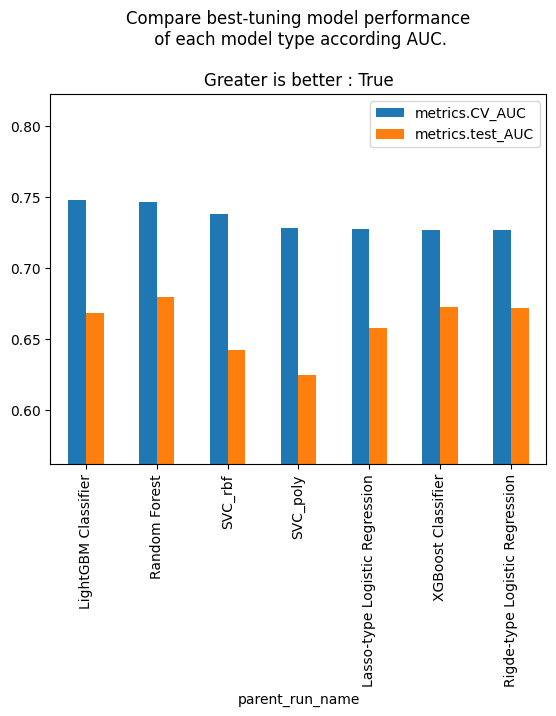

f2
top-15:


,run_id,metrics.CV_f2,metrics.test_f2,fit_time_s,parent_run_name
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.502994,0.398010,24.896,Random Forest
75,4090ba0636d64443a10f1b27ab8fbf0e,0.502092,0.397490,8.044,LightGBM Classifier
64,97f8ceb4f7a740e5afab268c1f61ea69,0.496098,0.410156,8.257,LightGBM Classifier
81,501752272e5a4ebdb5b91a1d5e97caee,0.493519,0.418410,37.901,Random Forest
38,293f72ac0fbb44a98e55950c3c7bd52c,0.492468,0.401460,7.896,LightGBM Classifier
112,e5225a720d2e4c1cb99c4405423b16fe,0.492063,0.406504,15.087,Random Forest
104,e8459dda04ff4e748fbee62f386fedd5,0.490731,0.384615,8.430,LightGBM Classifier
102,583c45e0c3d0433eb32cc6c50beff236,0.490376,0.411523,38.040,Random Forest
76,5a421afb372b4f26919e0f0b1c5b7f47,0.489899,0.427807,22.100,Random Forest
97,84ed62e9b6d0461195bf5fb2705ced81,0.487541,0.413223,10.732,LightGBM Classifier



best tuning for each model type:


,run_id,metrics.CV_f2,metrics.test_f2,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,260d4384e29a4c51a1388bfbda2af2f7,0.481651,0.394022,3.461
LightGBM Classifier,4090ba0636d64443a10f1b27ab8fbf0e,0.502092,0.397490,8.044
Random Forest,d8e0a324bfb94fc3bbfedf9c4d4360be,0.502994,0.398010,24.896
Rigde-type Logistic Regression,d1a9a4bf2fae476c8b5e3451677aa8d5,0.473204,0.394022,4.450
SVC_poly,e3288730c4e74207aa356f88bad20d0a,0.466102,0.351906,14.109
SVC_rbf,44a9bab20b94401583213e2c9bd6a7eb,0.480072,0.371622,26.418
XGBoost Classifier,05cc3d3e3bca472fb55c157fe71ff295,0.480000,0.403226,27.288


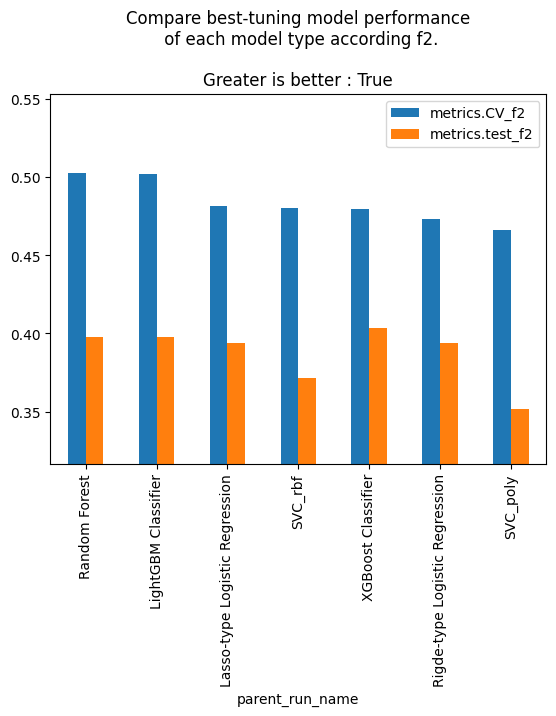

loss_of_income
top-15:


,run_id,metrics.CV_loss_of_income,metrics.test_loss_of_income,fit_time_s,parent_run_name
0,d8e0a324bfb94fc3bbfedf9c4d4360be,0.290625,0.3200,24.896,Random Forest
1,8732eae2be37434bb47447f0525dc63b,0.291250,0.3150,22.811,Random Forest
2,ea8d66f46e0f43709e647163f1ac73aa,0.294375,0.3675,4.123,Lasso-type Logistic Regression
3,126a09ec6b1c42c0b6f5484361feca6b,0.295625,0.3700,4.127,Lasso-type Logistic Regression
4,7ea45a4e57df49ffa98356522929c323,0.295625,0.3675,3.634,Lasso-type Logistic Regression
5,4572bea7814645cdaac2d46659cb0570,0.295625,0.3750,3.714,Lasso-type Logistic Regression
6,73584fdb25744214bf5a5a8dcc2789db,0.296250,0.3675,4.340,Lasso-type Logistic Regression
7,ae1caf1d42d84762b80e478a60983a86,0.296250,0.3675,4.336,Lasso-type Logistic Regression
8,e43dd70c864c4698ae87fe6838fb6e81,0.296250,0.3650,4.104,Lasso-type Logistic Regression
10,e921ec606fbc41caaed819b2ec8561fa,0.296875,0.3600,4.451,Lasso-type Logistic Regression



best tuning for each model type:


,run_id,metrics.CV_loss_of_income,metrics.test_loss_of_income,fit_time_s
parent_run_name,,,,
Lasso-type Logistic Regression,ea8d66f46e0f43709e647163f1ac73aa,0.294375,0.3675,4.123
LightGBM Classifier,293f72ac0fbb44a98e55950c3c7bd52c,0.304375,0.3475,7.896
Random Forest,d8e0a324bfb94fc3bbfedf9c4d4360be,0.290625,0.3200,24.896
Rigde-type Logistic Regression,131da8d8245b42ef87fe890a9728bf1d,0.301875,0.3575,5.145
SVC_poly,ff73ce5216cb452f8d47bde5d3b051cd,0.342500,0.3750,14.738
SVC_rbf,12b4802eebb84382ac5d6db9ab694b6e,0.330625,0.3675,24.900
XGBoost Classifier,705f72b891ea41e6aaf6fcd5d369ae6c,0.302500,0.3450,360.156


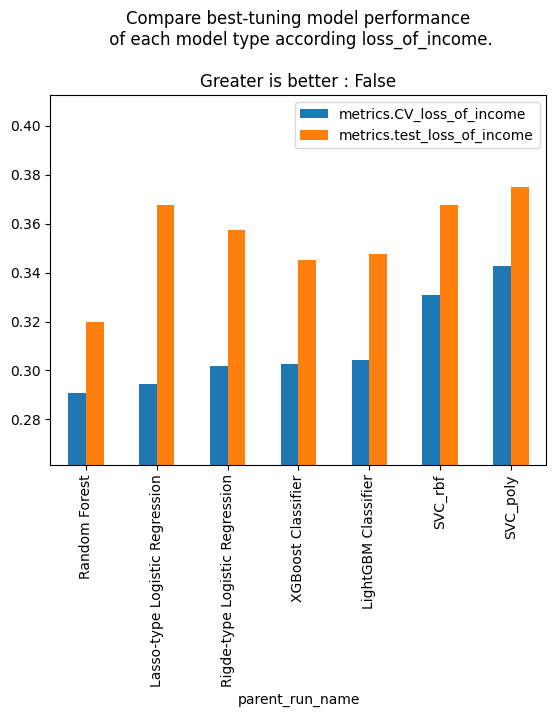

In [51]:
metrics = ['loss_of_income', 'AUC', 'f2']

for scorer_name, scorer in scorers.items():
    if scorer_name in metrics:
        print(scorer_name)
        cols = [col for col in results.columns if scorer_name in col]
        cols.append('fit_time_s')
        cols.append('parent_run_name')
        
        # Sort so the best models (regarding the score on CV) 
        # are in head().
        CV_metric_name = f'metrics.CV_{scorer_name}'
        results_per_metric = (
            results
            .loc[:, cols]
            .reset_index()
            .sort_values(
                CV_metric_name, 
                ascending=(not scorer.greater_is_better)
            )
        )
        
        print('top-15:')
        display(results_per_metric.head(10))
        # Get info on the best model of each model type.       
        best_tuning = (
            results_per_metric
            .groupby('parent_run_name')
            .first()
        )
        print('\nbest tuning for each model type:')
        display(best_tuning)
        
        # Focus on best metrics to print best performance per model type
        best_metrics = (
            best_tuning
            .sort_values(
                CV_metric_name,
                ascending=(not scorer.greater_is_better)
            ).iloc[:, -3:-1]
        )
        
        min_ = best_metrics.min().min()*0.9
        max_ = best_metrics.max().max()*1.1
        best_metrics.plot(
            kind='bar',
            title=(
                f'Compare best-tuning model performance\n '
                f'of each model type according {scorer.name}.\n'
                f'\nGreater is better : {scorer.greater_is_better}'
            )
        )
        ax = plt.gca()
        ax.set(ylim=(min_, max_))
        plt.show()        

In [52]:
scorers = utils.my_Scorers
optimization_scorer_name = 'loss_of_income'